# wavelet

## Overview
Computes the wavelet of time-series data
- NCL [wavelet](https://www.ncl.ucar.edu/Document/Functions/Built-in/wavelet.shtml)

### PyWavelets: Morlet Wavelet

The Morlet wavelet is a complex wavelet, with both a real and imaginary component. In PyWavelets this is known as a Complex Morlet (`"cmor"`).

NCL Morlet wavelet is based on _"A Practical Guide to Wavelet Analysis"_ (Torrence and Compo). However, PyWavelets functions are derived from _"Computational Signal Processing with Wavelets"_ (Teolis) to be compatible with how [Matlab is defined](https://www.mathworks.com/help/wavelet/ref/cmorwavf.html). 

To match the expected behavior of PyWavelets best to Torrence and Compo, the differences will be noted below.

### Define the Complex Morlet

PyWavelets defines a [Complex Morlet](https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#complex-morlet-wavelets) Mother wavelet as `cmorB-C` where B is the bandwidth and C is the center frequency.

To match the Morlet wavelet function being used by NCL (Torrence and Compo, Table 1) and the PyWavelets complex morlet (Teolis, pg. 65-66), set bandwidth value `B=sqrt(pi)` and center frequency `C=6/2*pi`

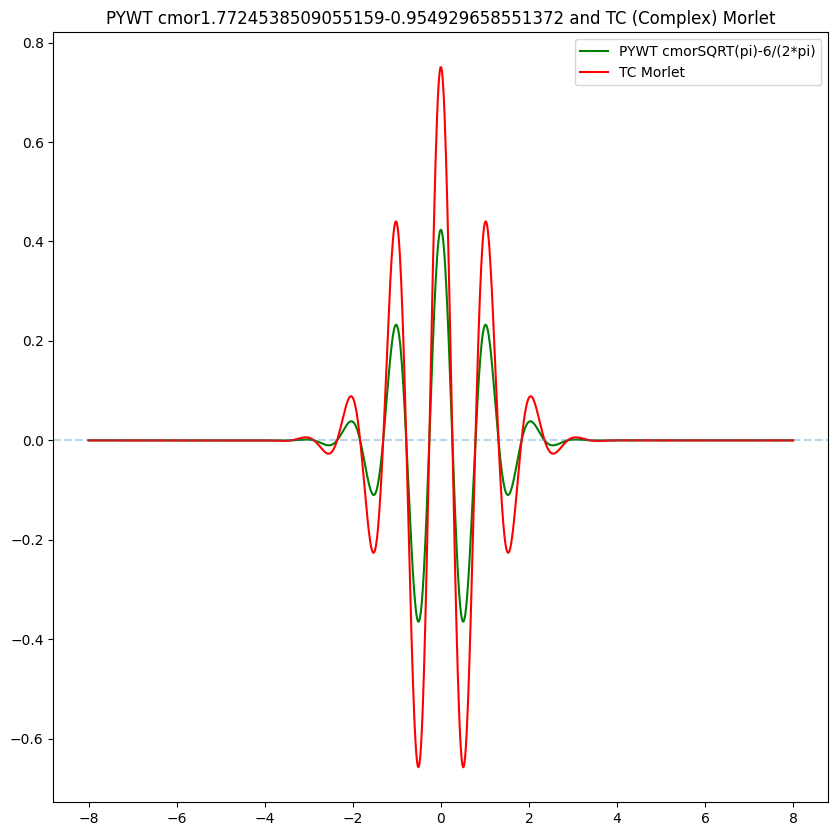

In [26]:
# Compare Complex Morlet NCL to PyWavelets
import pywt  # PyWavelets
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt  # plot data


def complex_morlet_pywavelets(time_step, B, C):
    # https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#complex-morlet-wavelets
    part1 = 1 / np.sqrt(math.pi * B)
    part2 = math.exp(-np.power(time_step, 2) / B)
    part3 = cmath.exp(1j * 2 * math.pi * C * time_step)
    return part1 * part2 * part3


def tc_morlet(time_step):
    # Table 1: https://psl.noaa.gov/people/gilbert.p.compo/Torrence_compo1998.pdf
    i = np.sqrt(-1 + 0j)  # complex i
    omega = 6  # w, nondimensional frequency, defaults to 6 (~2pi)
    eta = time_step  # n, wavelet function nondimensional "time" parameter
    part1 = np.power(math.pi, -1 / 4)
    part2 = cmath.exp(i * omega * eta)
    part3 = math.exp(-np.power(eta, 2) / 2)
    return part1 * part2 * part3


def morlet_pywavelets(time_step):
    # https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#morlet-wavelet
    # 'morl'
    part1 = math.exp(-np.power(time_step, 2) / 2)
    part2 = math.cos(5 * time_step)
    return part1 * part2


bandwidth = 2
center_freq = 6 / (2 * math.pi)  # C * 2 * pi = 2 * pi = approx 6 (morlet default)
amp_multiply = math.sqrt(2) * np.power(math.pi, 1 / 4)

complex_morlet = f"cmor{bandwidth}-{center_freq}"
[psi, x] = pywt.ContinuousWavelet(complex_morlet).wavefun(10)
[psi_default, x_default] = pywt.ContinuousWavelet(
    f"cmor{math.sqrt(math.pi)}-{center_freq}"
).wavefun(10)
[psi_m, x_m] = pywt.ContinuousWavelet('morl').wavefun(10)

tc_output = []
mor_pywt_output = []
cmor_pywt_output = []
for x_value in x:
    tc_output.append(tc_morlet(x_value))
    mor_pywt_output.append(morlet_pywavelets(x_value))
    cmor_pywt_output.append(complex_morlet_pywavelets(x_value, bandwidth, center_freq))

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(x, np.real(psi_default), label="PYWT cmorSQRT(pi)-6/(2*pi)", c="green")
ax.plot(x, np.real(tc_output), label="TC Morlet", c="red")
plt.title(f"PYWT cmor{math.sqrt(math.pi)}-{6/(2*math.pi)} and TC (Complex) Morlet")
ax.axhline(0, linestyle='--', alpha=0.3)
ax.legend()
plt.show()

### *Note*

The Complex Morlet in PyWavelets will match along the x-intercept, but will be a smaller amplitude by `2 * fourth root of pi`. The x-intercepts are the most important feature of the wavelet, but to match completely set bandwidth `B=2` and multiple entire output by `math.sqrt(2)*np.power(math.pi, 1/4)`

## Grab and Go

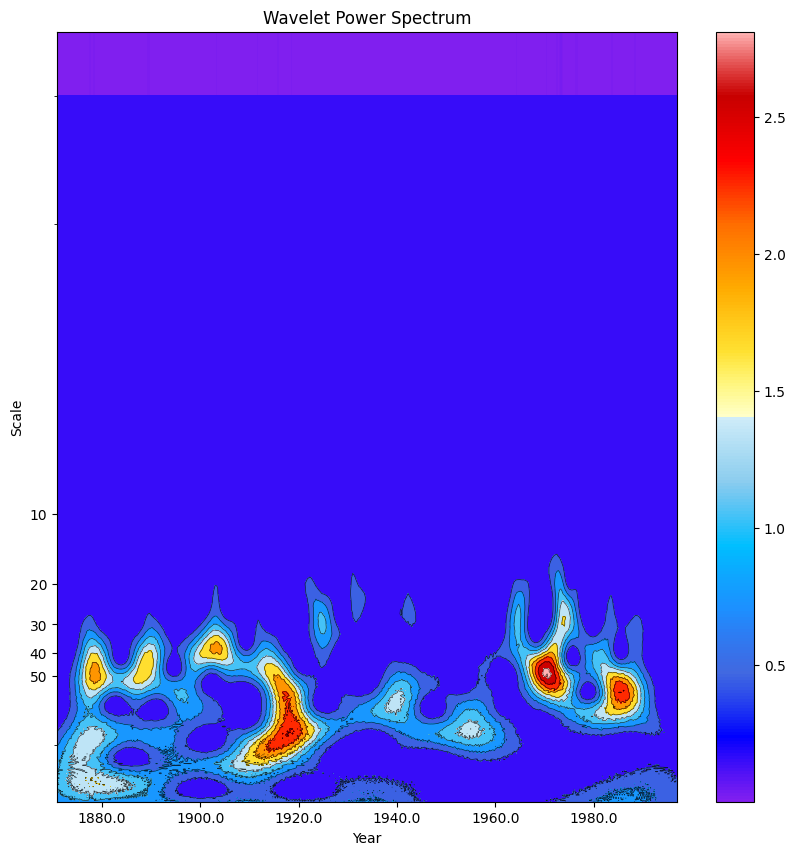

In [27]:
import math  # access to pi and square root (math.pi, math.sqrt)
import numpy as np  # access to complex numbers (real and imaginary)
import cmaps  # access to NCL default plot colors
import matplotlib.pyplot as plt  # plot data
import geocat.datafiles as gcd  # accessing nino 3 data file

import pywt  # PyWavelets

# Download nino3 data
nino3_data = gcd.get('ascii_files/sst_nino3.dat')
sst_data = np.loadtxt(nino3_data)

bandwidth = math.sqrt(math.pi)
center_freq = 6 / (2 * math.pi)
wavelet_mother = f"cmor{bandwidth}-{center_freq}"

# PyWavelet Input Values
dt = 0.25  # sampling period (time between each y-value)
s0 = 0.25  # smallest scale
dj = 0.25  # spacing between each discrete scales
jtot = 44  # largest scale
scales = np.arange(1, jtot + 1, dj)

# PyWavelets
wavelet_coeffs, freqs = pywt.cwt(
    data=sst_data, scales=scales, wavelet=wavelet_mother, sampling_period=dt
)

# compare the power spectrum (absolute value squared)
power = np.power((abs(wavelet_coeffs)), 2)

# Plot Power spectrum
fig, ax = plt.subplots(figsize=(10, 10))

# Convert Y-Axis from default to symmetrical log (symlog) with labels
ax.set_yscale("symlog")
ax.invert_yaxis()
ax.set_yticks([10, 20, 30, 40, 50])
ax.set_yticklabels([10, 20, 30, 40, 50])

# Plot contour around data
plt.contourf(
    power, vmax=(power).max(), vmin=(power).min(), cmap=cmaps.ncl_default, levels=10
)
plt.contour(power, levels=10, colors="k", linewidths=0.5, alpha=0.75)

# Plot Scalogram
plt.imshow(
    power, vmax=(power).max(), vmin=(power).min(), cmap=cmaps.ncl_default, aspect="auto"
)

# Convert default X-axis from time steps of 0-504 (0-len(sst_data)) to Years
start_year = 1871
end_year = 1871 + (len(sst_data) * dt)
x_tickrange = np.arange(start_year, end_year, dt)
start = int(9 / dt)  # 36, starts the x-axis label at 1880 (9 years after start of data)
display_nth = int(20 / dt)  # 80, display x-axis label every 20 years
plt.xticks(range(len(x_tickrange))[start::display_nth], x_tickrange[start::display_nth])

plt.title("Wavelet Power Spectrum")
plt.xlabel("Year")
plt.ylabel("Scale")
plt.colorbar()
plt.show()

## Python changes to approximate NCL functionality

In [28]:
# Set up `cmor` Complex Morlet to match x-intercept of NCL
bandwidth = math.sqrt(math.pi)
center_freq = 6 / (2 * math.pi)
wavelet_mother = f"cmor{bandwidth}-{center_freq}"
print(wavelet_mother)

cmor1.7724538509055159-0.954929658551372


## Python Resources

- [PyWavelets Continuous Wavelet Transform (CWT)](https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#pywt.cwt)
- [A Practical Guide to Wavelet Analysis (Torrence and Compo, 1998)](https://psl.noaa.gov/people/gilbert.p.compo/Torrence_compo1998.pdf)
- [A Really Friendly Guide to Wavelets (Valens, 1999)](https://www.cs.unm.edu/~williams/cs530/arfgtw.pdf)